In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from scipy.io import savemat
from matplotlib import pyplot as plt

from UQpy.scientific_machine_learning.neural_networks import DeepOperatorNetwork
from UQpy.scientific_machine_learning.trainers import BBBTrainer
from UQpy.scientific_machine_learning.layers.BayesianLayer import BayesianLayer
from UQpy.scientific_machine_learning.layers.BayesianConvLayer import BayesianConvLayer
from dataset import load_data, rescale

import logging

logger = logging.getLogger("UQpy")
logger.setLevel(logging.INFO)

In [2]:
priors = {
    "prior_mu": 0,
    "prior_sigma": 0.01,
    "posterior_mu_initial": (0, 0.1),
    "posterior_rho_initial": (-5, 0.1),
}

In [3]:

class BranchNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fnn = nn.Sequential(BayesianLayer(101, 100, priors=priors), nn.Tanh())
        self.conv_layers = nn.Sequential(
            BayesianConvLayer(1, 16, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
            BayesianConvLayer(16, 16, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
            BayesianConvLayer(16, 16, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
            BayesianConvLayer(16, 64, (5, 5), padding="same", priors=priors),
            nn.AvgPool2d(2, 1, padding=0),
        )
        self.dnn = nn.Sequential(
            nn.Flatten(),
            BayesianLayer(64 * 6 * 6, 512, priors=priors),
            nn.Tanh(),
            BayesianLayer(512, 512, priors=priors),
            nn.Tanh(),
            BayesianLayer(512, 200, priors=priors),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fnn(x)
        x = x.view(-1, 1, 10, 10)
        x = self.conv_layers(x)
        x = self.dnn(x)
        return x


In [4]:
class TrunkNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fnn = nn.Sequential(
            BayesianLayer(2, 128, priors=priors),
            nn.Tanh(),
            BayesianLayer(128, 128, priors=priors),
            nn.Tanh(),
            BayesianLayer(128, 128, priors=priors),
            nn.Tanh(),
            BayesianLayer(128, 200, priors=priors),
            nn.Tanh(),
        )
        self.Xmin = np.array([0.0, 0.0]).reshape((-1, 2))
        self.Xmax = np.array([1.0, 1.0]).reshape((-1, 2))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = 2.0 * (x - self.Xmin) / (self.Xmax - self.Xmin) - 1.0
        x = x.float()
        x = self.fnn(x)
        return x


In [5]:
branch_network = BranchNet()
trunk_network = TrunkNet()
model = DeepOperatorNetwork(branch_network, trunk_network, 2)

In [6]:
# Load datasets and create data loaders
class ElasticityDataSet(Dataset):
    """Load the Elasticity dataset"""

    def __init__(self, x, f_x, u_x, u_y):
        self.x = x
        self.f_x = f_x
        self.u_x = u_x
        self.u_y = u_y

    def __len__(self):
        return int(self.f_x.shape[0])

    def __getitem__(self, i):
        return self.x, self.f_x[i, :], (self.u_x[i, :, 0], self.u_y[i, :, 0])

(F_train,Ux_train, Uy_train, F_test, Ux_test, Uy_test,
    X, ux_train_mean, ux_train_std, uy_train_mean, uy_train_std,) = load_data()
train_data = DataLoader(
    ElasticityDataSet(
        np.float32(X), np.float32(F_train), np.float32(Ux_train), np.float32(Uy_train)
    ),
    batch_size=100,
    shuffle=True,
)
test_data = DataLoader(
    ElasticityDataSet(
        np.float32(X), np.float32(F_test), np.float32(Ux_test), np.float32(Uy_test)
    ),
    batch_size=100,
    shuffle=True,
)

In [7]:
class LossFunction(nn.Module):
    def __init__(self, reduction: str = "mean", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reduction = reduction

    def forward(self, prediction, label):
        return F.mse_loss(
            prediction[0], label[0], reduction=self.reduction
        ) + F.mse_loss(prediction[1], label[1], reduction=self.reduction)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = BBBTrainer(model, optimizer, LossFunction())

In [9]:
trainer.run(
    train_data=train_data,
    test_data=test_data,
    epochs=1000,
    tolerance=1e-4,
    beta=1e-8,
    num_samples=1,
)

[INFO] - 2024-05-16 10:58:07,132 - UQpy: Scientific Machine Learning: Beginning training and testing DeepOperatorNetwork
[INFO] - 2024-05-16 10:58:11,128 - UQpy: Scientific Machine Learning: Epoch 1 / 1,000 Train Loss 44.90986723648874 Train NLL 44.07970503756874 Train KL 83016216.0 Test NLL 9.500065803527832
[INFO] - 2024-05-16 10:58:15,075 - UQpy: Scientific Machine Learning: Epoch 2 / 1,000 Train Loss 6.856808285964163 Train NLL 6.025748554028962 Train KL 83105968.0 Test NLL 2.323637008666992
[INFO] - 2024-05-16 10:58:19,024 - UQpy: Scientific Machine Learning: Epoch 3 / 1,000 Train Loss 3.8570807984000757 Train NLL 3.025841656484102 Train KL 83123920.0 Test NLL 2.029174566268921
[INFO] - 2024-05-16 10:58:22,955 - UQpy: Scientific Machine Learning: Epoch 4 / 1,000 Train Loss 3.18944209500363 Train NLL 2.358229687339381 Train KL 83121232.0 Test NLL 2.0012998580932617
[INFO] - 2024-05-16 10:58:26,905 - UQpy: Scientific Machine Learning: Epoch 5 / 1,000 Train Loss 2.802559174989399 Tra

KeyboardInterrupt: 

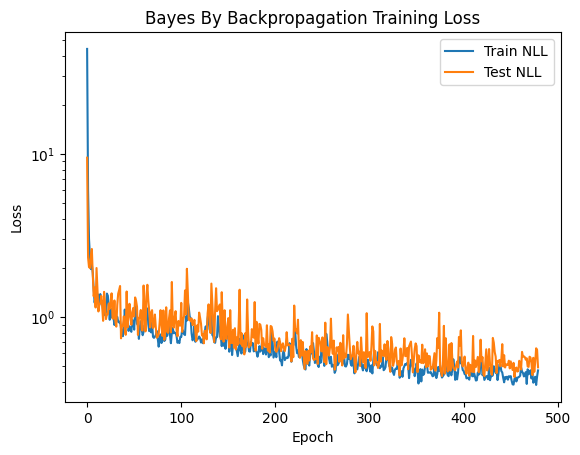

In [17]:
train_loss = trainer.history["train_nll"].detach().numpy()
test_loss = trainer.history["test_nll"].detach().numpy()
fig, ax = plt.subplots()
ax.plot(train_loss, label = 'Train NLL')
ax.plot(test_loss, label = 'Test NLL')
ax.set_title("Bayes By Backpropagation Training Loss")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()
ax.set_yscale('log')

In [11]:
# Evaluate test data and save results
def eval_model(test_data,model,uq=False):
    if uq:
        model.train()
    else:
        model.eval()
    ux_pred_list = []
    uy_pred_list = []
    ux_test_list = []
    uy_test_list = []
    x_list = []
    for batch_number, (*x, y) in enumerate(test_data):
        ux_pred, uy_pred = model(*x)
        ux_test , uy_test = y
        ux_pred_list.append(ux_pred)
        uy_pred_list.append(uy_pred)
        ux_test_list.append(ux_test)
        uy_test_list.append(uy_test)
        x_list.append(x[1][:,0,:])
    return torch.cat(ux_pred_list), torch.cat(uy_pred_list), torch.cat(ux_test_list), torch.cat(uy_test_list), torch.cat(x_list)

In [12]:
ux_pred, uy_pred, ux_test, uy_test, x_test = eval_model(test_data,model)
ux_pred = rescale(ux_pred.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_pred = rescale(uy_pred.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))
ux_test = rescale(ux_test.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_test = rescale(uy_test.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))

In [13]:
num_uq_samps = 100
ux_pred_list = []
uy_pred_list = []
for i in range(num_uq_samps):
    ux_samp_pred, uy_samp_pred, _, _,_  = eval_model(test_data,model,uq=True)
    ux_samp_pred = rescale(ux_samp_pred.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
    uy_samp_pred = rescale(uy_samp_pred.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))
    ux_pred_list.append(ux_samp_pred)
    uy_pred_list.append(uy_samp_pred)
ux_sigma = np.std(ux_pred_list,axis=0)
uy_sigma = np.std(uy_pred_list,axis=0)
    

In [14]:
savemat('Bayesian_Elastic_plate.mat',{'x_test': x_test.detach().numpy(), 'ux_test': ux_test.detach().numpy(), 'uy_test': uy_test.detach().numpy(), 
                              'ux_pred': ux_pred.detach().numpy(), 'uy_pred': uy_pred.detach().numpy(), 'ux_sigma': ux_sigma, 'uy_sigma': uy_sigma} )